In [1]:
import gin.torch
import wandb
from torch.utils.data import DataLoader
from tqdm.notebook import  tqdm

from src.aae.models import AugmentedAutoEncoder
from src.aae.dataset import OnlineRenderer

@gin.configurable
def train_aae(num_workers: int=gin.REQUIRED,
              num_train_iters: int=gin.REQUIRED,
              save_interval: int=gin.REQUIRED,
              cache_interval: int=gin.REQUIRED,
              device: str=gin.REQUIRED):
    
    model = AugmentedAutoEncoder()
    # wandb.watch(model)
    model = model.to(device)
    
    dataset = OnlineRenderer()
    dl = DataLoader(dataset,
               batch_size=dataset.batch_size,
               shuffle=True,
               # num_workers=num_workers)
               num_workers=0)
    
    iters = num_train_iters // dataset.batch_size
    
    for idx, _ in tqdm(enumerate(range(iters))):
        
        cache_recon = (idx % cache_interval == 0)

        for data in dl:
            aug, target, pose = data
            model.optimize_params(data, device=device, cache_recon=cache_recon)
            
            break
        break
    return model
gin.add_config_file_search_path('../')
gin.parse_config_file('../config/train/linemod/obj_0001.gin')

# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

ParsedConfigFileIncludesAndImports(filename='../config/train/linemod/obj_0001.gin', imports=['src.aae.dataset'], includes=[ParsedConfigFileIncludesAndImports(filename='../config/camera.gin', imports=['src.aae.Renderer'], includes=[]), ParsedConfigFileIncludesAndImports(filename='../config/aae.gin', imports=[], includes=[])])

In [2]:
model = train_aae()
cached_recon = model.cached_recon

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


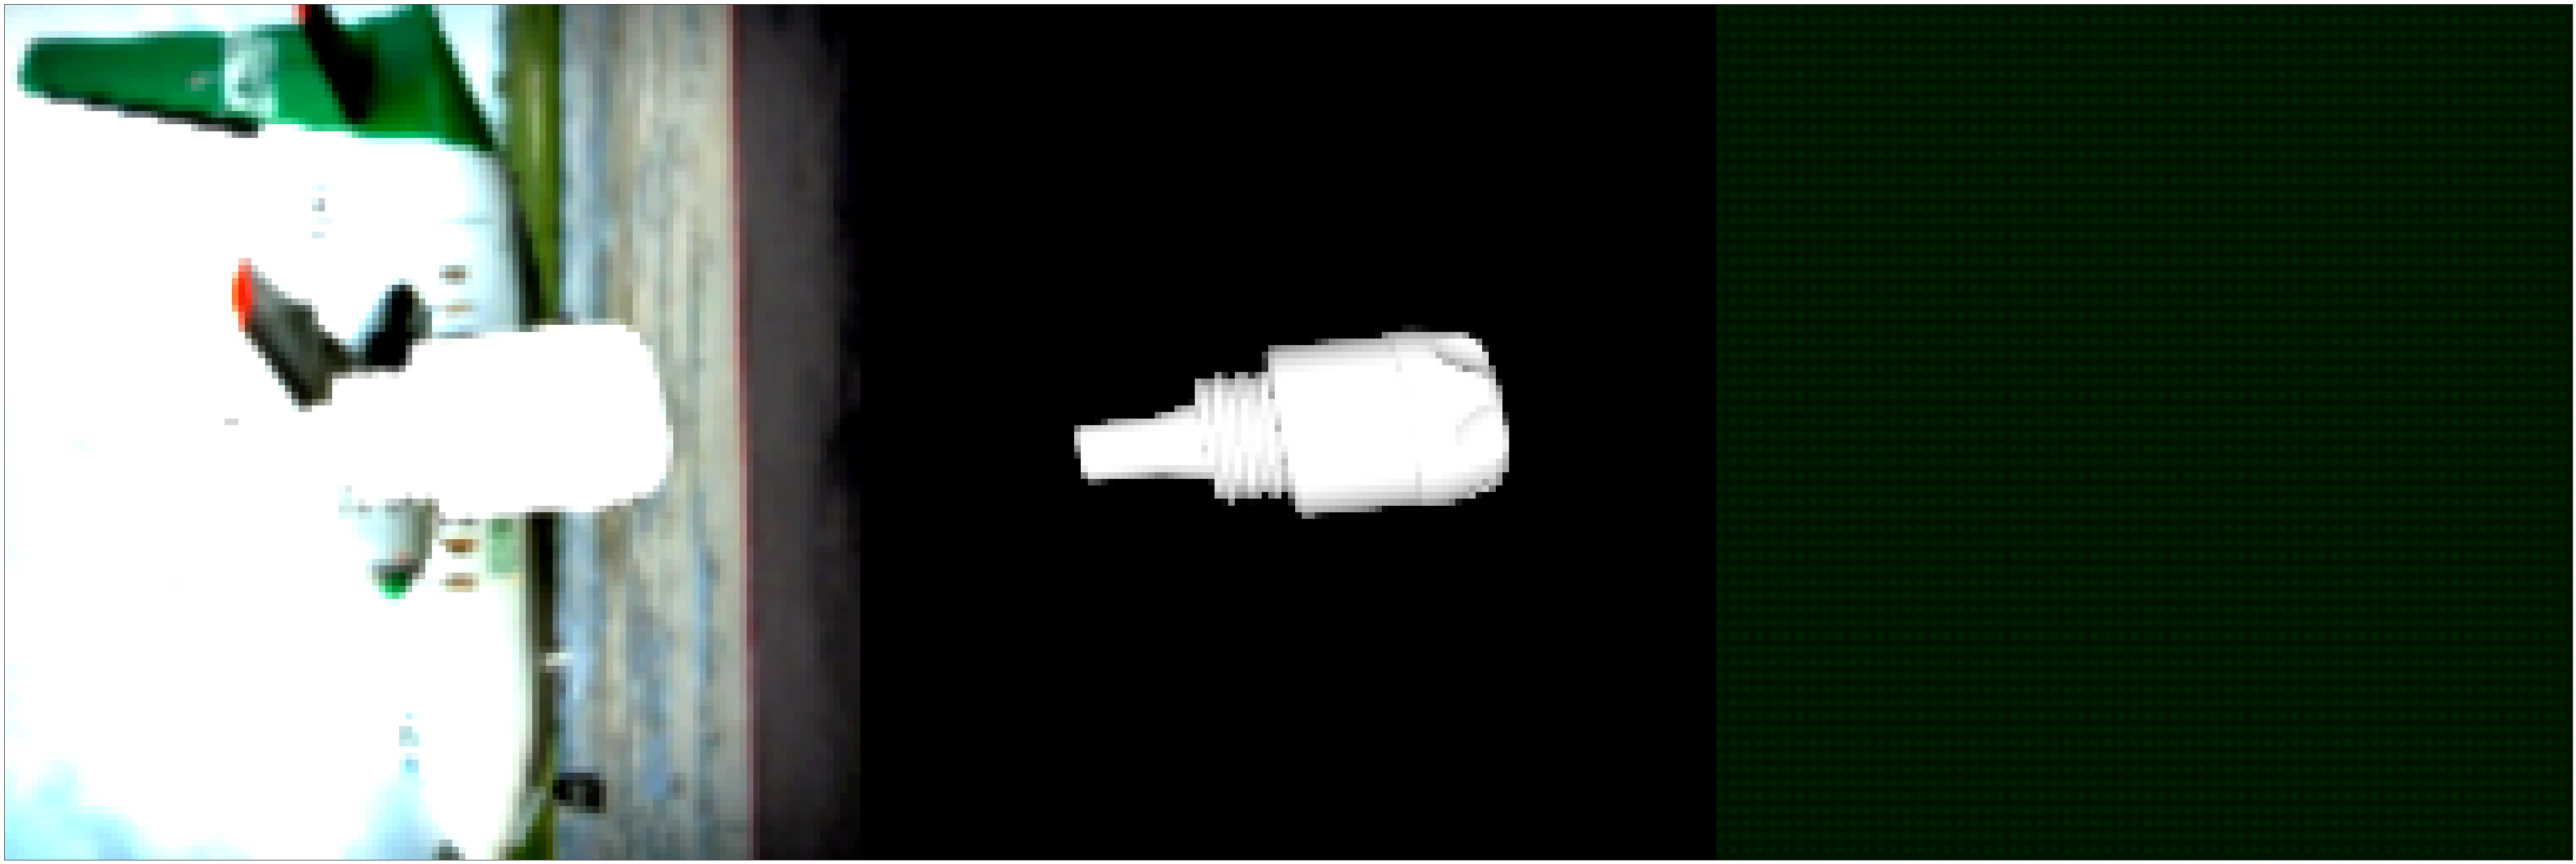

In [45]:
from typing import List

%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np


def plot_im(im):
    fig = plt.figure(figsize=(60, 30), tight_layout=True)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    fig.set_tight_layout(True)
    im = im.transpose(2, 1, 0) 
    plt.imshow(im)
    
    
def combine_in_out_imgs(imgs: List[np.array], axis: int) -> np.array:                                                                                                                      
    # NOTE: torch img dim (N, C, H, W) ¬
    return np.concatenate(imgs, axis=axis)     

im_reels = np.stack([combine_in_out_imgs(s, -2) for s in cached_recon])

combined_reel = combine_in_out_imgs(im_reels, -1)

step = im_reels.shape[0] // 4
reel1, reel2 = combine_in_out_imgs(im_reels[:step], -1), combine_in_out_imgs(im_reels[step:step * 2], -1)
reel3, reel4 = combine_in_out_imgs(im_reels[step * 2: step * 3], -1), combine_in_out_imgs(im_reels[step*3:], -1)

split_reel = combine_in_out_imgs((reel1, reel2, reel3, reel4), -2)


plot_im(im_reels[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


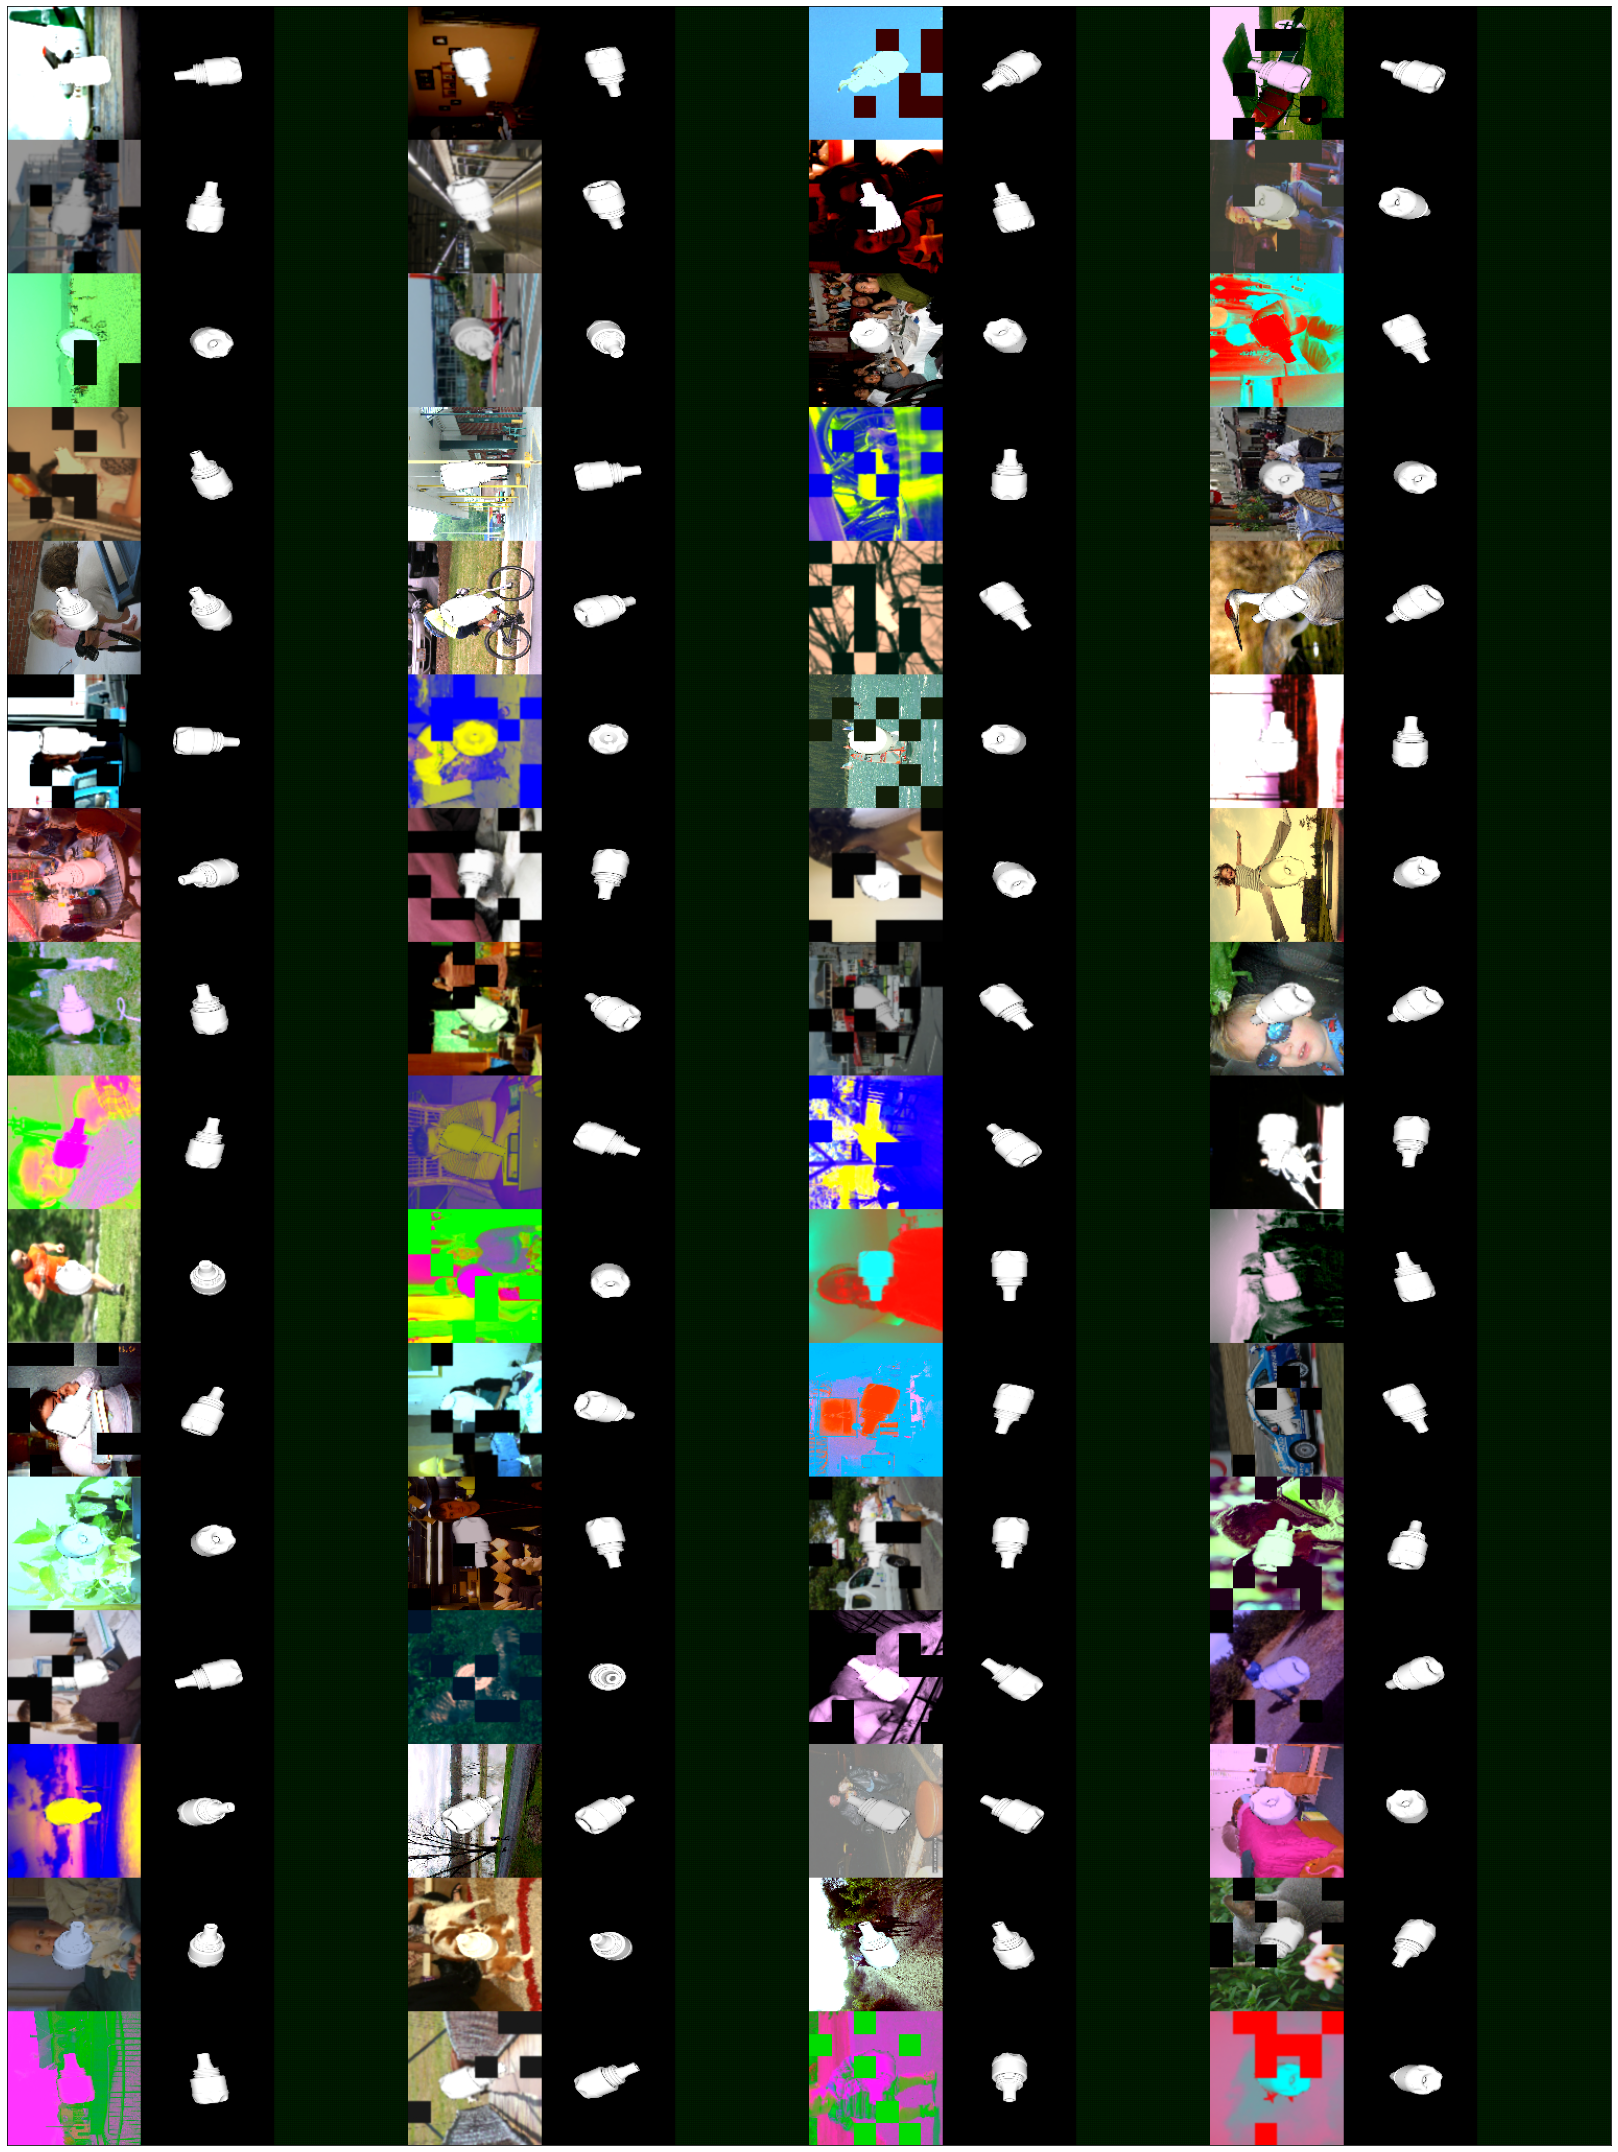

In [48]:
plot_im(split_reel)